## 6-1 パイプラインの使い方

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_  # M => 1, B => 0

array(['B', 'M'], dtype=object)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression
from sklearn.pipeline      import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))


Test accuracy: 0.956


## 6-2 k分割交差検証 / 層化k分割検証

* ホールドアウト法  : train_test_split
* k分割交差検証     : cross_valid_score
* 層化k分割交差検証 : cross_valid_score(stratify='xxx') or StratifiedKFold 

In [17]:
from sklearn.model_selection import StratifiedKFold
KFold = StratifiedKFold(n_splits=10).split(X_train, y_train)

In [21]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

KFold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(KFold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

print('\ncv accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

cv accuracy: 0.950 +/- 0.014


Class dist は、そのループの学習において、クラス0とクラス1のデータをそれぞれ何個使ったかを表している。

KFold は何をしているのかがわかりやすいが、cross_valid_score を使えば１行で処理を書くことが可能。

In [6]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe_lr, X_train, y_train, cv=10, n_jobs=1)
scores

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

## 6-3 学習曲線と検証曲線

* バイアスが高い   : モデルが単純すぎて、データに対応できてない
* バリアンスが高い : モデルが複雑すぎて、過学習を起こしている

### 学習曲線

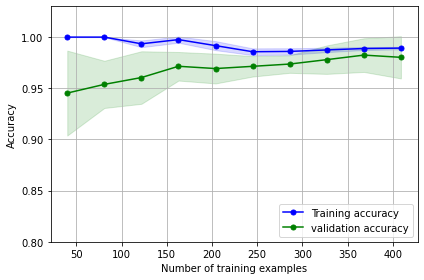

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr2 = make_pipeline(StandardScaler(),
                         LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr2, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### 検証曲線

(6,)


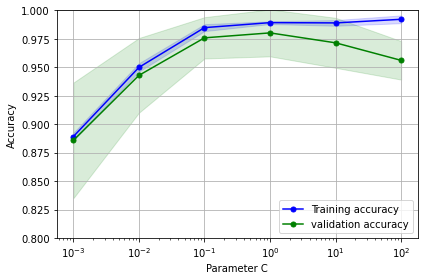

In [8]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr2, X=X_train, y=y_train, 
                                                param_name='logisticregression__C',param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)
print(train_mean.shape)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='o', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## 6-4 グリッドサーチ

* 複数のハイパーパラメータの**組み合わせ**に対して最適なものを網羅的な手法で見つける

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs.fit(X_train, y_train)
print("best score", gs.best_score_)
print("best params",gs.best_params_)

best score 0.9846859903381642
best params {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [10]:
bestclf = gs.best_estimator_
bestclf.fit(X_train, y_train)

print('Test accuracy: %.3f' % bestclf.score(X_test, y_test))

Test accuracy: 0.974


## 6-5 さまざまな性能評価指標

In [11]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[71,  1],
       [ 2, 40]])

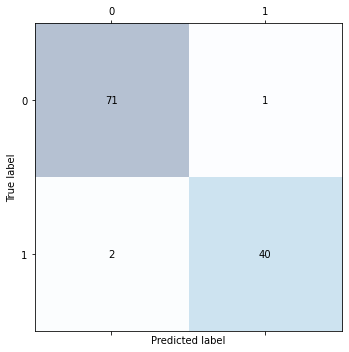

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

* 正解率 (= 1 - 誤分類率) : 正しく予測できたものの割合
* 適合率(精度) : 見つけたい対象として予測したののうち、どれだけ間違いがなかったか
* 再現率 : 予測したい対象をどれだけくまなく見つけられたか
* F1スコア : 適合率と再現率の調和平均

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision 0.976
Recall 0.952
F1 0.964


GridSearch に用いる評価指標を選択できる

In [21]:
from sklearn.metrics import make_scorer, f1_score

c_gamma_range = [0.01, 0.1, 1.0, 10]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.9861994953378878


In [22]:
print(gs.best_params_)

{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### ROC曲線とAUC

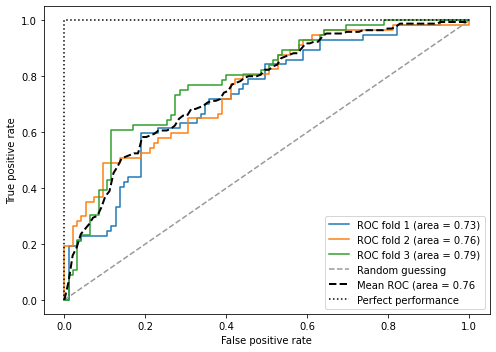

In [27]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipi_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0))

X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc) )

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing') # 当て水量の直線

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], 
         linestyle=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [40]:
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
probas[:, 1]

array([0.43831216, 0.10538766, 0.54410801, 0.25175549, 0.14389532,
       0.46054812, 0.14177744, 0.20388469, 0.45898724, 0.28629721,
       0.27893907, 0.0189126 , 0.09399532, 0.26301483, 0.10305184,
       0.6825371 , 0.44889221, 0.59836635, 0.40838455, 0.23590881,
       0.64302046, 0.61020599, 0.14022997, 0.38275001, 0.42742997,
       0.70514923, 0.41324686, 0.24843776, 0.52128125, 0.44315217,
       0.49477334, 0.85006768, 0.2143769 , 0.31281242, 0.19268763,
       0.10084631, 0.63713216, 0.17271594, 0.23060053, 0.33674823,
       0.08574895, 0.58628178, 0.32706184, 0.21095539, 0.36420869,
       0.50510806, 0.58758918, 0.34605446, 0.92061264, 0.38932846,
       0.49811098, 0.77079237, 0.15082499, 0.38755446, 0.98022072,
       0.92808967, 0.09412573, 0.48465711, 0.33988435, 0.28225486,
       0.63401487, 0.13895359, 0.21710158, 0.52768058, 0.66614331,
       0.32477045, 0.31554921, 0.19374851, 0.49328853, 0.50258667,
       0.32393549, 0.60966565, 0.53860511, 0.3510305 , 0.29140

## 6-6 クラスの不均衡性への対処

* 性能指標に正解率を使わず、再現率や適合率を使う
* 少数派クラスデータのアップサンプリング、多数派クラスデータのダウンサンプリング
* 少数派クラスデータの間違いには、大きなペナルティを課す
* 前提として、どのようなケースにも対応できる手法は存在しない